In [282]:
import datetime 
from dateutil.relativedelta import *
import os
import re 
import string
import nltk
import pandas as pd 
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

import matplotlib.pyplot as plt 

from collections import OrderedDict
import langdetect 
from langdetect import DetectorFactory , detect_langs # for dermining language  
DetectorFactory.seed = 0

from google_trans_new import google_translator  # translating words
translator = google_translator()  

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

%matplotlib inline

In [201]:
'''Utility Functions'''
def concat_all_dataframes():
    ''' 
    Here we are going to combine all of the training csv's
    Into 1 dataframe that we can use for preprocessing
    
    adjust the path to whereever you are holding the data
    '''
    path = os.path.join(os.getcwd(),'google_scraping','data')
    csvs = os.listdir(path)
    output = pd.DataFrame()
    
    count = 0
    for csv in csvs:
        temp = pd.read_csv(os.path.join(path,csv))
        count += 1 
        
        if output.empty:
            output = temp        
        else:
            output = pd.concat([output,temp],axis=0)

    output.reset_index(inplace=True)        
    return output

def preprocessing_text(df):
    '''
    Here we are going to clean the text to be in a good format for further analysis 
    
    input: df ; DataFrame object that contains all of the reviews. 
    '''
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    lemm = WordNetLemmatizer()
    df = df.loc[~df.caption.isnull()] # here we are going to only process reviews 
    df= df.loc[~df.caption.str.contains('Translated by Google')]
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(str.lower)
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: re.sub(r'[^\w\s]','',review)) # removes punctuation
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: re.sub('\([^()]*\)','',review)) # removes words within parenthesis 
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    df.loc[:,'caption'] = df.loc[:,'caption'].apply(lambda review: emoji_pattern.sub(r'', review)) 
    df.loc[:,'caption_split'] = df.loc[:,'caption'].apply(lambda review: review.split(' '))
    
    clean_reviews = []
    for review_idx , review in df.caption_split.items():
        for idx, word in enumerate(review):
            review[idx] = lemm.lemmatize(word)
        
        review_  = ' '.join(review)
        clean_reviews.append(review_)
    
    df.loc[:,'caption'] = clean_reviews
    
    df.drop(['index'],axis=1,inplace=True)
    return df


def rating_by_loc(df):
    # here we are going to return the locations that the 
    temp = pd.DataFrame(df.groupby(['address']).rating.value_counts(normalize=True)).sort_index(ascending=True).unstack()
    temp.fillna(0,inplace=True)
    output = {}
    for row in temp.iterrows():
        output[row[0]] = row[1]['rating']
    
    return output
        
def plot_rating_by_loc(d,key):
    # given a key, we are going to be able to plot the rating distribution for that location.
    # the format of the key is 
    d[key].plot(kind='bar');
    plt.title(f'Distribution of ratings from BJs {key} Google Reviews');
    plt.xlabel('rating score');
    plt.xticks(rotation=0)
    plt.ylabel('percent');
    
def translating_names(df):
    # Here we are going to be cleaning and preprocessing the 
    # data to be in the format that we need to then create the labels for.
    
    ''': 
    need to first translate the names that to not have english characters.
    need to do regular expressions in order to get rid of certain characters 
    '''      
    for  idx , row in df.iterrows():
        print(idx)
        num = np.random.randint(1,3,size=1)[0]
        time.sleep(num)
        eng_word = translator.translate(row['name'],lang_tgt='en').strip()
        df.loc[idx,'name'] = eng_word
    return  


def create_language_col(df):
    # Here are we going to make a column of the language of the name
    df['language'] = None 
    for row in df.iterrows():
        
        if row[0] == 150:
            continue
        else:
            
            lang = detect_langs(row[1]['caption'].split('(Original) ')[-1]).pop().__repr__()[:2]
            df.loc[row[0],'language'] = lang

    return df

In [133]:
test = concat_all_dataframes()
processed_reviews = preprocessing_text(test)

c:\users\tiam moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\tiam moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\tiam moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [215]:
test

,index,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,address
0,0,ChZDSUhNMG9nS0VJQ0FnSUR5eGZUVkdREAE,When I call on the phone they keep transferrin...,3 weeks ago,2021-04-05 22:07:32.493050,1.0,Nicole Fernandez,1,0,https://www.google.com/maps/contrib/1167544312...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
1,1,ChZDSUhNMG9nS0VJQ0FnSUR5NGNteFp3EAE,NaN,3 weeks ago,2021-04-05 22:07:32.495406,5.0,Moraima Salguero,1,0,https://www.google.com/maps/contrib/1031710714...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
2,2,ChZDSUhNMG9nS0VJQ0FnSUR5em91dFZ3EAE,I brought my car in for a nail in my tire. Whe...,4 weeks ago,2021-04-05 22:07:32.496056,1.0,Eric Goll,4,0,https://www.google.com/maps/contrib/1069048977...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
3,3,ChZDSUhNMG9nS0VJQ0FnSUN5OGJPSVJREAE,NaN,2 months ago,2021-04-05 22:07:32.498080,3.0,MEDAMED,0,0,https://www.google.com/maps/contrib/1075382770...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
4,4,ChZDSUhNMG9nS0VJQ0FnSUN5OGRHYVNnEAE,This review is for Tire Shop. Set up appointme...,2 months ago,2021-04-05 22:07:32.499050,5.0,Casmor,0,0,https://www.google.com/maps/contrib/1128938745...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
...,...,...,...,...,...,...,...,...,...,...,...,...
9648,98,ChZDSUhNMG9nS0VJQ0FnSUNRcGNyNEhBEAE,NaN,5 years ago,2021-04-05 00:44:34.223940,5.0,jojo jojo,0,0,https://www.google.com/maps/contrib/1110428637...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"
9649,99,ChZDSUhNMG9nS0VJQ0FnSUNnNXNueE9nEAE,I have saved a lot of money shopping at BJ's…,5 years ago,2021-04-05 00:44:34.236201,4.0,Mary Goodwin,2,0,https://www.google.com/maps/contrib/1129140405...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"
9650,100,ChdDSUhNMG9nS0VJQ0FnSURnXzdqRjF3RRAB,(Translated by Google) Normal shop and gas sta...,5 years ago,2021-04-05 00:45:01.082954,5.0,Vadim Fissenko,2,0,https://www.google.com/maps/contrib/1030645562...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"
9651,101,ChZDSUhNMG9nS0VJQ0FnSUNRb3FlN1ZREAE,Allows you to piggy back on coupons unlike ano...,5 years ago,2021-04-05 00:45:01.086511,5.0,Beth Burnham,0,0,https://www.google.com/maps/contrib/1005247209...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"


### The distribution of ratings for BJs locations in general

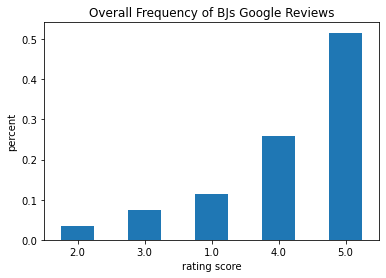

In [84]:
test.rating.value_counts(normalize=True).sort_values(ascending=True).plot(kind='bar');
plt.title('Overall Frequency of BJs Google Reviews');
plt.xlabel('rating score');
plt.xticks(rotation=0)
plt.ylabel('percent');

### Distribution of rating scores by location

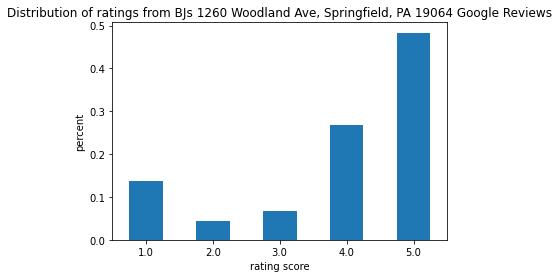

In [284]:
output = rating_by_loc(test)
plot_rating_by_loc(output,'1260 Woodland Ave, Springfield, PA 19064')

In [139]:
test

,index,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,address
0,0,ChZDSUhNMG9nS0VJQ0FnSUR5eGZUVkdREAE,When I call on the phone they keep transferrin...,3 weeks ago,2021-04-05 22:07:32.493050,1.0,Nicole Fernandez,1,0,https://www.google.com/maps/contrib/1167544312...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
1,1,ChZDSUhNMG9nS0VJQ0FnSUR5NGNteFp3EAE,NaN,3 weeks ago,2021-04-05 22:07:32.495406,5.0,Moraima Salguero,1,0,https://www.google.com/maps/contrib/1031710714...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
2,2,ChZDSUhNMG9nS0VJQ0FnSUR5em91dFZ3EAE,I brought my car in for a nail in my tire. Whe...,4 weeks ago,2021-04-05 22:07:32.496056,1.0,Eric Goll,4,0,https://www.google.com/maps/contrib/1069048977...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
3,3,ChZDSUhNMG9nS0VJQ0FnSUN5OGJPSVJREAE,NaN,2 months ago,2021-04-05 22:07:32.498080,3.0,MEDAMED,0,0,https://www.google.com/maps/contrib/1075382770...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
4,4,ChZDSUhNMG9nS0VJQ0FnSUN5OGRHYVNnEAE,This review is for Tire Shop. Set up appointme...,2 months ago,2021-04-05 22:07:32.499050,5.0,Casmor,0,0,https://www.google.com/maps/contrib/1128938745...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
...,...,...,...,...,...,...,...,...,...,...,...,...
9648,98,ChZDSUhNMG9nS0VJQ0FnSUNRcGNyNEhBEAE,NaN,5 years ago,2021-04-05 00:44:34.223940,5.0,jojo jojo,0,0,https://www.google.com/maps/contrib/1110428637...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"
9649,99,ChZDSUhNMG9nS0VJQ0FnSUNnNXNueE9nEAE,I have saved a lot of money shopping at BJ's…,5 years ago,2021-04-05 00:44:34.236201,4.0,Mary Goodwin,2,0,https://www.google.com/maps/contrib/1129140405...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"
9650,100,ChdDSUhNMG9nS0VJQ0FnSURnXzdqRjF3RRAB,(Translated by Google) Normal shop and gas sta...,5 years ago,2021-04-05 00:45:01.082954,5.0,Vadim Fissenko,2,0,https://www.google.com/maps/contrib/1030645562...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"
9651,101,ChZDSUhNMG9nS0VJQ0FnSUNRb3FlN1ZREAE,Allows you to piggy back on coupons unlike ano...,5 years ago,2021-04-05 00:45:01.086511,5.0,Beth Burnham,0,0,https://www.google.com/maps/contrib/1005247209...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"


In [193]:
x = test[~test.caption.isnull()]
x = x[x.caption.str.contains('(Translated by Google)') == True].reset_index()

x

c:\users\tiam moradi\anaconda3\envs\loseit\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,level_0,index,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,address
0,10,10,ChdDSUhNMG9nS0VJQ0FnSURpb2JUQy13RRAB,(Translated by Google) I found everything I wa...,4 months ago,2021-04-05 22:07:32.514095,5.0,Evangelio Molina,0,0,https://www.google.com/maps/contrib/1154775365...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
1,11,11,ChZDSUhNMG9nS0VJQ0FnSURpX3RIOE9BEAE,(Translated by Google) REGULAR (Original) REG...,4 months ago,2021-04-05 22:07:32.516052,2.0,RONEY DELGADO,0,0,https://www.google.com/maps/contrib/1101099861...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
2,12,12,ChZDSUhNMG9nS0VJQ0FnSURpc29LT1NBEAE,(Translated by Google) The gas station hardly ...,4 months ago,2021-04-05 22:07:32.518056,2.0,Osvaldo Nunez,0,0,https://www.google.com/maps/contrib/1077906203...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
3,19,19,ChdDSUhNMG9nS0VJQ0FnSUNDdk1yYW93RRAB,(Translated by Google) The tire service is ter...,7 months ago,2021-04-05 22:07:32.534052,1.0,jesus quinones,1,0,https://www.google.com/maps/contrib/1172769880...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
4,28,28,ChZDSUhNMG9nS0VJQ0FnSUNjbDRHV09BEAE,(Translated by Google) Buy my tires there. I w...,9 months ago,2021-04-05 22:07:58.831343,2.0,Mariamer Torres,0,0,https://www.google.com/maps/contrib/1184011542...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,8896,110,ChdDSUhNMG9nS0VJQ0FnSUNBdThTeDVRRRAB,(Translated by Google) Simply wonderful. Much ...,3 years ago,2021-04-11 20:47:44.496820,5.0,Mima Tineo,3,0,https://www.google.com/maps/contrib/1108285265...,https://www.google.com/maps/place/BJ's+Wholesa...,"70 Cluff Rd, Salem, NH 03079"
276,9001,71,ChdDSUhNMG9nS0VJQ0FnSUNRa09yRGhBRRAB,(Translated by Google) Love going to BJs. (Or...,3 years ago,2021-04-05 01:23:13.943596,5.0,Crystal bixby,0,0,https://www.google.com/maps/contrib/1156108713...,https://www.google.com/maps/place/BJ's+Wholesa...,"4408 Milestrip Rd, Blasdell, NY 14219"
277,9040,110,ChZDSUhNMG9nS0VJQ0FnSUNBLWVqdk13EAE,(Translated by Google) Blahing (Original) Bla...,3 years ago,2021-04-05 01:25:04.744099,5.0,Dolores Battle,8,0,https://www.google.com/maps/contrib/1107854572...,https://www.google.com/maps/place/BJ's+Wholesa...,"4408 Milestrip Rd, Blasdell, NY 14219"
278,9603,53,ChZDSUhNMG9nS0VJQ0FnSUNnelk3V2NBEAE,(Translated by Google) GreT (Original) GreT,3 years ago,2021-04-05 00:42:46.266948,5.0,Michael Dascanio,1,0,https://www.google.com/maps/contrib/1164024599...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103"


### Number of reviews that were translated: 247

### Here are locations with the most translated reviews.

In [375]:
x_no_english.address.value_counts()[:10]

7007 SW 117th Ave, Miami, FL 33183              58
300 NJ-17, East Rutherford, NJ 07073            28
101 S Van Dorn St, Alexandria, VA 22304         16
13700 Pines Blvd, Pembroke Pines, FL 33027      15
278 Middlesex Ave, Medford, MA 02155            14
396 Marin Blvd, Jersey City, NJ 07302           13
1000 Old Nichols Rd, Islandia, NY 11749         11
500 N State Rd 7, Royal Palm Beach, FL 33411     8
2044 Red Lion Rd, Philadelphia, PA 19115         8
1785 Airport Rd, Allentown, PA 18109             6
Name: address, dtype: int64

### Creating a language col to determine which languages are being spoken.

In [202]:
x = create_language_col(x)

In [373]:
x_no_english = x.loc[x.language !='en']
x_no_english

,level_0,index,id_review,caption,relative_date,retrieval_date,rating,username,n_review_user,n_photo_user,url_user,url_source,address,language
0,10,10,ChdDSUhNMG9nS0VJQ0FnSURpb2JUQy13RRAB,(Translated by Google) I found everything I wa...,4 months ago,2021-04-05 22:07:32.514095,5.0,Evangelio Molina,0,0,https://www.google.com/maps/contrib/1154775365...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183",es
1,11,11,ChZDSUhNMG9nS0VJQ0FnSURpX3RIOE9BEAE,(Translated by Google) REGULAR (Original) REG...,4 months ago,2021-04-05 22:07:32.516052,2.0,RONEY DELGADO,0,0,https://www.google.com/maps/contrib/1101099861...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183",de
2,12,12,ChZDSUhNMG9nS0VJQ0FnSURpc29LT1NBEAE,(Translated by Google) The gas station hardly ...,4 months ago,2021-04-05 22:07:32.518056,2.0,Osvaldo Nunez,0,0,https://www.google.com/maps/contrib/1077906203...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183",es
3,19,19,ChdDSUhNMG9nS0VJQ0FnSUNDdk1yYW93RRAB,(Translated by Google) The tire service is ter...,7 months ago,2021-04-05 22:07:32.534052,1.0,jesus quinones,1,0,https://www.google.com/maps/contrib/1172769880...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183",es
5,29,29,ChZDSUhNMG9nS0VJQ0FnSURjdXZ2RU53EAE,(Translated by Google) Excellent for shopping ...,9 months ago,2021-04-05 22:07:58.832341,5.0,Emerita Nodarse,2,0,https://www.google.com/maps/contrib/1131259189...,https://www.google.com/maps/place/BJ's+Wholesa...,"7007 SW 117th Ave, Miami, FL 33183",es
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,8884,98,ChdDSUhNMG9nS0VJQ0FnSURBdGZ5bG5RRRAB,(Translated by Google) There is everything you...,3 years ago,2021-04-11 20:46:51.469836,5.0,Lidy Hiraldo,0,0,https://www.google.com/maps/contrib/1055243851...,https://www.google.com/maps/place/BJ's+Wholesa...,"70 Cluff Rd, Salem, NH 03079",es
275,8896,110,ChdDSUhNMG9nS0VJQ0FnSUNBdThTeDVRRRAB,(Translated by Google) Simply wonderful. Much ...,3 years ago,2021-04-11 20:47:44.496820,5.0,Mima Tineo,3,0,https://www.google.com/maps/contrib/1108285265...,https://www.google.com/maps/place/BJ's+Wholesa...,"70 Cluff Rd, Salem, NH 03079",pt
277,9040,110,ChZDSUhNMG9nS0VJQ0FnSUNBLWVqdk13EAE,(Translated by Google) Blahing (Original) Bla...,3 years ago,2021-04-05 01:25:04.744099,5.0,Dolores Battle,8,0,https://www.google.com/maps/contrib/1107854572...,https://www.google.com/maps/place/BJ's+Wholesa...,"4408 Milestrip Rd, Blasdell, NY 14219",tl
278,9603,53,ChZDSUhNMG9nS0VJQ0FnSUNnelk3V2NBEAE,(Translated by Google) GreT (Original) GreT,3 years ago,2021-04-05 00:42:46.266948,5.0,Michael Dascanio,1,0,https://www.google.com/maps/contrib/1164024599...,https://www.google.com/maps/place/BJ's+Wholesa...,"513 Warren Ave, Portland, ME 04103",de


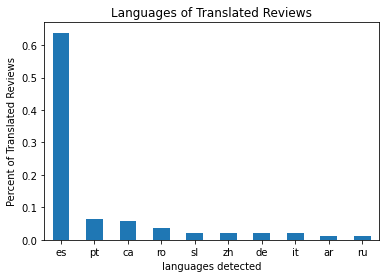

In [374]:
# spanish, Portugese,Catalan,Romanian,Slovenian,Chinese(sino-tibetan),German,Italian,Arabic,Russian
x_no_english.language.value_counts(normalize=True)[:10].plot(kind='bar');
plt.title('Languages of Translated Reviews')
plt.xlabel('languages detected');
plt.ylabel('Percent of Translated Reviews');
plt.xticks(rotation=0);

### Looking at 4 / 5 grams by rating of reviews to see if there are any unique phrases. (by ratings) 

In [353]:
# if not good, go back to 2-3
tfidf5 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
tfidf4 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
tfidf3 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
tfidf2 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')
tfidf1 = TfidfVectorizer(max_features=50,ngram_range=(3,5),stop_words='english')

#########################################################################
# This section is going to be for the Topic Modelling 
tfidf5_ = TfidfVectorizer(max_features=50,stop_words='english')
tfidf4_ = TfidfVectorizer(max_features=50,stop_words='english')
tfidf3_ = TfidfVectorizer(max_features=50,stop_words='english')
tfidf2_ = TfidfVectorizer(max_features=50,stop_words='english')
tfidf1_ = TfidfVectorizer(max_features=50,stop_words='english')

#### Here we are seperating the reviews based on the rating score

In [354]:
processed_reviews_five = processed_reviews.loc[processed_reviews.rating == 5,'caption']
processed_reviews_four = processed_reviews.loc[processed_reviews.rating == 4,'caption']
processed_reviews_three = processed_reviews.loc[processed_reviews.rating == 3,'caption']
processed_reviews_two = processed_reviews.loc[processed_reviews.rating == 2,'caption']
processed_reviews_one = processed_reviews.loc[processed_reviews.rating == 1,'caption']

#### Here we are getting different Tf-Idf Matricies for each group

In [355]:
tfidf_five_star = tfidf5.fit_transform(processed_reviews_five)
tfidf_four_star = tfidf4.fit_transform(processed_reviews_four)
tfidf_three_star = tfidf3.fit_transform(processed_reviews_three)
tfidf_two_star = tfidf2.fit_transform(processed_reviews_two)
tfidf_one_star = tfidf1.fit_transform(processed_reviews_one)

#### Creating Document Term Matricies and n-grams for 5 star reviews

In [356]:
tfidf5_s = pd.Series(tfidf5.vocabulary_)
tfidf5_s=tfidf5_s.to_frame()
tfidf5_s['n-gram'] = tfidf5_s.index
tfidf5_s.index = range(len(tfidf5_s.index))
tfidf5_s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams5 = tfidf5_s.loc[~tfidf5_s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams5

,value_count,n-gram
39,38,staff wa helpful
40,37,staff friendly helpful
25,36,save lot money
36,35,place shop bulk
30,34,place buy bulk
8,33,original muy bueno
12,32,original muy buena
44,31,original love bjs
20,30,original excelente lugar
35,29,nice place shop


In [357]:
lda_rating_5 = tfidf5_.fit_transform(processed_reviews_five)
lda_rating_5_pd = pd.DataFrame(lda_rating_5.toarray(),columns=tfidf5_.get_feature_names())

#### Creating Document Term Matricies and n-grams for 4 star reviews

In [358]:
tfidf4s = pd.Series(tfidf4.vocabulary_)
tfidf4s=tfidf4s.to_frame()
tfidf4s['n-gram'] = tfidf4s.index
tfidf4s.index = range(len(tfidf4s.index))
tfidf4s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams4= tfidf4s.loc[~tfidf4s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams4

,value_count,n-gram
28,49,typical wholesale club
13,43,store great price
46,42,store friendly staff
19,41,self checkout lane
43,40,selection pretty good
36,39,selection great price
27,38,sam club bjs
26,37,place shop bulk need
24,36,place shop bulk
39,35,place buy item


In [359]:
lda_rating_4 = tfidf4_.fit_transform(processed_reviews_four)
lda_rating_4_pd = pd.DataFrame(lda_rating_4.toarray(),columns=tfidf4_.get_feature_names())

#### Creating Document Term Matricies and n-grams for 3 star reviews

In [360]:
tfidf3.vocabulary_

tfidf3_s = pd.Series(tfidf3.vocabulary_)
tfidf3_s=tfidf3_s.to_frame()
tfidf3_s['n-gram'] = tfidf3_s.index
tfidf3_s.index = range(len(tfidf3_s.index))
tfidf3_s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams3 = tfidf3_s.loc[~tfidf3_s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams3

,value_count,n-gram
29,49,wa busy talking
38,48,typical wholesale club
18,47,self checkout lane
12,46,selection great price
2,45,price sold bulk track cost
1,44,price sold bulk track
0,43,price sold bulk
40,42,price shaw stop shop
39,41,price shaw stop
8,40,price service wa rate


In [361]:
lda_rating_3 = tfidf3_.fit_transform(processed_reviews_three)
lda_rating_3_pd = pd.DataFrame(lda_rating_3.toarray(),columns=tfidf3_.get_feature_names())

#### Creating Document Term Matricies and n-grams for 2 star reviews

In [362]:
tfidf2.vocabulary_

tfidf2_s = pd.Series(tfidf2.vocabulary_)
tfidf2_s=tfidf2_s.to_frame()
tfidf2_s['n-gram'] = tfidf2_s.index
tfidf2_s.index = range(len(tfidf2_s.index))
tfidf2_s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams = tfidf2_s.loc[~tfidf2_s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams

,value_count,n-gram
9,49,terrible customer service
27,48,self service check
1,47,ran coca cola come
0,46,ran coca cola
22,45,ramming cart heel im checking
21,44,ramming cart heel im
20,43,ramming cart heel
14,42,raise price month
13,41,raise owings location higher standard
12,40,raise owings location higher


In [363]:
lda_rating_2 = tfidf2_.fit_transform(processed_reviews_two)
lda_rating_2_pd = pd.DataFrame(lda_rating_2.toarray(),columns=tfidf2_.get_feature_names())

#### Creating Document Term Matricies and n-grams for 1 star reviews

In [364]:
tfidf1.vocabulary_
tfidf1_s = pd.Series(tfidf1.vocabulary_)
tfidf1_s=tfidf1_s.to_frame()
tfidf1_s['n-gram'] = tfidf1_s.index
tfidf1_s.index = range(len(tfidf1_s.index))
tfidf1_s.rename({0:'value_count'},axis=1,inplace=True)

top_n_grams = tfidf1_s.loc[~tfidf1_s['n-gram'].str.contains('google')].sort_values('n-gram',ascending = False)
top_n_grams

,value_count,n-gram
5,49,worst customer service
2,48,worse customer service
9,47,wont renewing membership
7,46,went customer service
35,45,week half ago refuse issue
25,44,week half ago refuse
13,43,week half ago
49,42,wa told wa
23,41,wa supposed arrive week
31,40,ups just issued ticket


In [365]:
lda_rating_1 = tfidf1_.fit_transform(processed_reviews_one)
lda_rating_1_pd = pd.DataFrame(lda_rating_1.toarray(),columns=tfidf1_.get_feature_names())

### Topic Modelling by ratings

In [366]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 3
model5 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model4 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model3 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model2 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model1 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [367]:
model5.fit(lda_rating_5_pd)
model4.fit(lda_rating_4_pd)
model3.fit(lda_rating_3_pd)
model2.fit(lda_rating_2_pd)
model1.fit(lda_rating_1_pd)

LatentDirichletAllocation(n_components=3, random_state=0)

In [333]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

### Topics for Model 5 

In [368]:
display_topics(model5,lda_rating_5_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,good,222.2,great,163.4,love,140.6
1,wa,100.0,service,90.0,price,102.0
2,translated,84.2,place,84.2,great,92.1
3,google,84.2,nice,75.3,shop,80.6
4,original,83.4,excellent,70.4,shopping,74.8
5,need,72.7,bulk,69.2,staff,74.1
6,bjs,68.4,deal,60.8,selection,73.8
7,best,66.4,buy,52.1,helpful,72.3
8,price,65.5,item,49.9,bjs,66.8
9,store,65.1,customer,49.1,friendly,66.1


### Topics for Model 4

In [369]:
display_topics(model4,lda_rating_4_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,great,55.3,place,50.1,good,131.5
1,bjs,50.6,store,44.7,price,87.3
2,wa,48.9,staff,41.5,selection,46.0
3,service,38.3,nice,40.2,item,39.6
4,need,37.2,clean,37.6,shopping,35.4
5,gas,27.2,helpful,34.3,coupon,34.7
6,club,25.9,bulk,34.3,love,32.1
7,google,24.5,shop,34.2,product,30.3
8,translated,24.3,like,33.9,line,29.4
9,original,24.0,friendly,30.7,deal,28.7


### Topics for Model 3

In [370]:
display_topics(model3,lda_rating_3_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,item,21.5,wa,22.0,good,32.2
1,store,17.3,bjs,17.4,service,15.2
2,need,16.0,line,15.8,costco,12.8
3,great,15.9,long,13.4,customer,12.6
4,gas,10.3,like,12.7,shopping,12.2
5,price,10.0,location,12.3,dont,11.5
6,way,9.1,time,11.5,price,11.0
7,coupon,8.5,just,11.4,place,10.9
8,bulk,8.3,help,10.7,lot,10.8
9,food,8.2,ok,10.0,store,10.7


### Topics for Model 2

In [371]:
display_topics(model2,lda_rating_2_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,wa,29.3,item,15.0,service,17.7
1,bjs,17.6,price,14.8,customer,14.4
2,store,11.3,time,14.6,line,13.2
3,membership,10.8,people,11.1,long,9.8
4,cart,9.6,coupon,9.5,checkout,9.5
5,good,9.6,place,9.3,rude,9.0
6,need,9.2,open,7.5,self,8.6
7,dont,8.7,great,6.4,employee,8.3
8,ha,7.8,store,6.4,im,8.1
9,shopping,7.1,better,6.2,staff,7.8


### Topics for Model 1

In [372]:
display_topics(model1,lda_rating_1_pd.columns,10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,wa,66.2,tire,53.7,rude,45.0
1,service,63.7,item,44.2,place,43.1
2,customer,54.4,people,34.8,membership,42.1
3,bad,33.0,wa,33.3,store,38.1
4,bjs,31.1,check,31.4,employee,37.6
5,coupon,23.6,cashier,28.9,dont,32.0
6,hour,23.6,minute,26.8,manager,29.6
7,help,23.0,line,25.9,customer,26.3
8,didnt,21.8,location,25.7,staff,24.9
9,day,21.7,need,25.3,ha,23.8


## Takeaways per Rating ( Both N-grams and Topic Modelling ) 

### Reviews with 5 star ratings

- [x] staff being friendly / helpful
- [x] great place to buy in bulk
- [x] great customer service 
- [x] good prices

### Reviews with 4 star ratings

- [x] n-grams were very similar to 5 star ratings 


### Reviews with 3 star ratings
- [x] parking lot 
- [x] priced items were wrong 
- [x] long line 
- [x] costco better 
- [x] gas and possible relation to price


### Reviews with 2 star ratings 
- [x] terrible customer service
- [x] raised prices
- [x] question supervisor
- [x] gas prices
- [x] lack organic products
- [x] long checkout like
- [x] employee's or other staff being rude 

### Reviews with 1 star ratings 
- [x] worst/rude customer service
- [x] refuse issue / issue refund delivery ticket 
- [x] not renewing membership
- [x] things taking a long with delivery / online ordering 
- [x] don't buy tire 